In [1]:
# Imports

import os
from pathlib import Path
from xml.etree import ElementTree
from os.path import join as pathjoin
import numpy as np
from PIL import Image
import gc
import pickle
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import time



In [2]:
# Method to load images and store them as numpy binarys

def images_to_numpy(voc_path):
    # Please provide this path
    voc_path = voc_path

    store_path = pathjoin(voc_path,'resized_images_as_pickle')
    if not os.path.isdir(store_path):
        os.mkdir(store_path)

    for file in os.listdir(pathjoin(voc_path, 'JPEGImages_resized')):
        filename = os.path.splitext(file)[0]
        if os.path.isfile(pathjoin(store_path, filename+'.pickle')):
            pass
        else:
            image_path = pathjoin(voc_path, 'JPEGImages_resized', filename+'.jpg')
            image = np.asarray(Image.open(image_path))
            with open(pathjoin(store_path, filename+'.pickle'), 'wb') as file:
                pickle.dump(image, file)


# Create the labels to the corresponding images from the xml files and store the labels as pickle as well
                
def labels_to_pickle(voc_path):
    voc_path = voc_path
    if os.path.isfile(pathjoin(voc_path, 'labels_resized.pickle')):
        pass
    else:
        xml_path = pathjoin(voc_path, 'Annotations')
        labels = []
        for file in os.listdir(pathjoin(voc_path, 'resized_images_as_pickle')):
            tree = ElementTree.parse(pathjoin(xml_path, os.path.splitext(file)[0]+'.xml'))
            root = tree.getroot()
            labels.append(set([obj.find('name').text for obj in root.findall('.//object')]))
        with open(pathjoin(voc_path, 'labels_resized.pickle'), 'wb') as f:
            pickle.dump(labels, f)

In [3]:
# create a dataframe with binary labels

def get_voc_labels(voc_path):
    voc_path = voc_path
    labels = []
    image_names = []
    for file in os.listdir(pathjoin(voc_path, 'resized_images_as_pickle')):
        image_names.append(os.path.splitext(file)[0])
            
    with open(pathjoin(voc_path, 'labels_resized.pickle'), 'rb') as label_file:
        labels = pickle.load(label_file)

    label_series = pd.Series(labels)

    mlb = MultiLabelBinarizer()

    label_df = pd.DataFrame(mlb.fit_transform(labels),
                       columns=mlb.classes_,
                       index=image_names)
    
    return label_df



# Load the numpy-images from the pickle files

def get_voc_images(voc_path: Path, image_names):
    voc_path = voc_path
    images = []
    for file in image_names:
        image_path = pathjoin(voc_path, 'resized_images_as_pickle', file+'.pickle')
        with open(image_path, 'rb') as image_file:
            images.append(pickle.load(image_file))
            
    return images
    

In [4]:
# Define the Path of the VOC-data

voc_path = Path("/home/robin/Downloads/VOCdevkit/VOC2012")

In [5]:
# pickle images and labels
images_to_numpy(voc_path)
labels_to_pickle(voc_path)

In [6]:
# create the labels dataframe
label_df = get_voc_labels(voc_path)
label_df.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,diningtable,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor
2010_000621,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2008_000244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2011_002715,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2012_003277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2011_002590,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [7]:
def print_image(images, label_df, number):
    image = Image.fromarray(images[number])
    import matplotlib.pyplot as plt
    plt.imshow(image)
    print('Label: {}\nBinary Label: {}'.format(list(label_df.columns), list(new_label_df.iloc[number])))

In [8]:
# method to load data for a specific set of labels
# it returns images for whom at least one of the labels is 1 and the corresponding label dataframe
# if classes is None or empty it returns the whole dataset

def get_data(voc_path: Path, label_df: pd.DataFrame , classes: list):
    if classes == None or len(classes)==0:
        classes = list(label_df.columns)
    new_label_df = label_df[(label_df[classes]!=[0,0,0,0,0]).any(axis=1)][classes]
    images = get_voc_images(voc_path, list(new_label_df.index))
    
    return new_label_df, images

In [9]:
# create data with transportation

transport_keys = ['car', 'bus', 'aeroplane', 'boat', 'train']
new_label_df, images = get_data(voc_path, label_df, transport_keys)

In [10]:
new_label_df.head()

,car,bus,aeroplane,boat,train
2010_004263,1,1,0,0,0
2009_002000,1,0,0,0,0
2010_002937,0,0,0,0,1
2008_006368,0,0,0,0,1
2009_001865,0,0,0,0,1


Label: ['car', 'bus', 'aeroplane', 'boat', 'train']
Binary Label: [1, 1, 0, 0, 0]


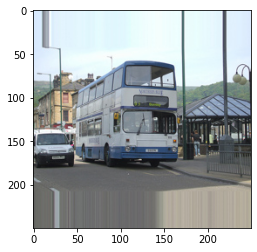

In [11]:
print_image(images, new_label_df, -1)

# Modeling

In [12]:
# split data for training

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, new_label_df.values, test_size=0.1, random_state=42)
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

classes = list(new_label_df.columns)

In [13]:
print('Number of train images: {}\nNumber of test images: {}'.format(len(train_images), len(test_images)))

Number of train images: 2991
Number of test images: 333


In [14]:
import matplotlib.pyplot as plt

def pred(model, i):
    prediction = model.predict(np.array([test_images[i]]))
    plt.imshow(test_images[i])
    print('Correct Label: {}\n'.format(classes[test_labels[i][0]]))
    for i in range(len(classes)):
        print('{}:\t\t {:.2f}'.format(classes[i], prediction[0][i]))
    print('\nNetwork Decision: {}'.format(classes[np.argmax(prediction)]))

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, AveragePooling2D, Dropout
import numpy as np
import tensorflow as tf

# if GPU is used
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

Using TensorFlow backend.


vgg_model = Sequential()
vgg_model.add(Conv2D(input_shape=train_images[0].shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg_model.add(Flatten())
vgg_model.add(Dense(units=2048,activation="relu"))
vgg_model.add(Dropout(rate=0.1))
vgg_model.add(Dense(units=1024,activation="relu"))
vgg_model.add(Dense(units=len(classes), activation="sigmoid"))

vgg_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

vgg_model.summary()

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

vgg_hist = vgg_model.fit_generator(steps_per_epoch=25,generator=traindata, validation_data= testdata, validation_steps=10,epochs=50,callbacks=[checkpoint,early])
pred(vgg_model, 10)

In [17]:
#create model
easy_model = Sequential()
easy_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=train_images[0].shape))
easy_model.add(MaxPool2D((2, 2)))
easy_model.add(Conv2D(64, (3, 3), activation='relu'))
easy_model.add(MaxPool2D((2, 2)))
easy_model.add(Conv2D(128, (3, 3), activation='relu'))
easy_model.add(Conv2D(256, kernel_size=3, activation='relu', ))
easy_model.add(Flatten())
easy_model.add(Dense(40, activation='relu'))
easy_model.add(Dense(len(classes), activation='sigmoid'))

In [18]:
easy_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
easy_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 57, 256)       295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 831744)           

In [20]:
easy_hist = easy_model.fit(train_images, train_labels, epochs=100, batch_size=64, callbacks=[checkpoint,early])

Epoch 1/100
2991/2991 [==============================] - 45s 15ms/step - loss: 34.9140 - accuracy: 0.7529
Epoch 2/100


/home/robin/miniconda3/envs/tf_env/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/robin/miniconda3/envs/tf_env/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2991/2991 [==============================] - 9s 3ms/step - loss: 0.6785 - accuracy: 0.7830
Epoch 3/100
2991/2991 [==============================] - 9s 3ms/step - loss: 0.6672 - accuracy: 0.7830
Epoch 4/100
2991/2991 [==============================] - 9s 3ms/step - loss: 0.6563 - accuracy: 0.7830
Epoch 5/100
2991/2991 [==============================] - 9s 3ms/step - loss: 0.6460 - accuracy: 0.7830
Epoch 6/100
2991/2991 [==============================] - 9s 3ms/step - loss: 0.6363 - accuracy: 0.7830
Epoch 7/100
2991/2991 [==============================] - 9s 3ms/step - loss: 0.6271 - accuracy: 0.7830
Epoch 8/100
2991/2991 [==============================] - 9s 3ms/step - loss: 0.6185 - accuracy: 0.7830
Epoch 9/100
2991/2991 [==============================] - 9s 3ms/step - loss: 0.6104 - accuracy: 0.7830
Epoch 10/100
2991/2991 [==============================] - 9s 3ms/step - loss: 0.6028 - accuracy: 0.7830
Epoch 11/100
2991/2991 [==============================] - 9s 3ms/step - loss: 0.5957

Correct Label: car

car:		 0.39
bus:		 0.14
aeroplane:		 0.21
boat:		 0.17
train:		 0.18

Network Decision: car


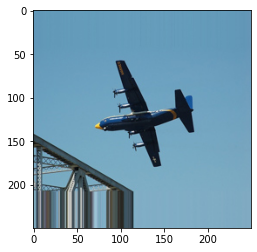

In [27]:
pred(easy_model, 70)

In [26]:
easy_model.predict(np.asarray([test_images[100]]))

array([[0.38836756, 0.14109018, 0.21265589, 0.16736463, 0.17743771]],
      dtype=float32)